### Install packages

In [12]:
!pip -q install lightgbm xgboost gymnasium stable-baselines3 tensorboard pandas numpy scikit-learn
import numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
import gymnasium as gym
from gymnasium import spaces
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import random
import seaborn as sns

### Load Dataset

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
test = pd.read_csv('/content/drive/MyDrive/Reinforcement Learning Project/energy-forecasting-data-challenge-public/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Reinforcement Learning Project/energy-forecasting-data-challenge-public/train.csv')

In [ ]:
test.head()

In [ ]:
train.head()

Refer to metadata here: https://www.kaggle.com/competitions/energy-forecasting-data-challenge-public/data

### Data EDA, Preprocessing, and Feature Engineering

In [ ]:
test.describe()

In [ ]:
test.nunique()

,0
time,7392
Gb(i),2554
Gd(i),3255
H_sun,2737
T2m,2271
WS10m,494
dataset_id,11


# Basline Gradient Boosting Model


## Data Preparation

### Subtask:
Convert the 'time' column to datetime objects, extract time-based features (year, month, day, hour, day of week, day of year), and define features (X) and target (y = 'load') from the training dataset.


In [16]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Reinforcement Learning Project/energy-forecasting-data-challenge-public/train.csv')

train['time'] = pd.to_datetime(train['time'])

train['year'] = train['time'].dt.year
train['month'] = train['time'].dt.month
train['day'] = train['time'].dt.day
train['hour'] = train['time'].dt.hour
train['dayofweek'] = train['time'].dt.dayofweek
train['dayofyear'] = train['time'].dt.dayofyear

# Define features (X) and target (y)
features = ['year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']
X = train[features]
y = train['load']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:")
print(X.head())
print("First 5 values of y:")
print(y.head())

Shape of X: (88712, 11)
Shape of y: (88712,)
First 5 rows of X:
   year  month  day  hour  dayofweek  dayofyear  Gb(i)  Gd(i)  H_sun   T2m  \
0  2018      1    1     0          0          1    0.0    0.0    0.0  9.11   
1  2018      1    1     0          0          1    0.0    0.0    0.0  8.89   
2  2018      1    1     0          0          1    0.0    0.0    0.0  8.66   
3  2018      1    1     0          0          1    0.0    0.0    0.0  8.44   
4  2018      1    1     1          0          1    0.0    0.0    0.0  8.22   

   WS10m  
0   5.38  
1   5.43  
2   5.48  
3   5.54  
4   5.59  
First 5 values of y:
0    113.5
1    119.0
2    117.5
3    114.5
4    123.0
Name: load, dtype: float64


## Data Splitting

### Subtask:
Split the prepared data into training and validation sets based on time, using a portion of the data for validation.


**Reasoning**:
To prepare the data for model training, I will split the features (X) and target (y) into training and validation sets. The split will be based on time, with the first 80% of the data used for training and the remaining 20% for validation.



In [17]:
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (70969, 11)
Shape of y_train: (70969,)
Shape of X_val: (17743, 11)
Shape of y_val: (17743,)


## Model Training

### Subtask:
Initialize and train a LightGBM Regressor model using the training data.


**Reasoning**:
To train the LightGBM model, I need to import the LGBMRegressor class, instantiate it, and then fit it to the training data (X_train and y_train).



In [18]:
import lightgbm as lgb

# Initialize the LightGBM Regressor model with additional hyperparameters
model = lgb.LGBMRegressor(random_state=42,
                          n_estimators=1000,
                          learning_rate=0.05,
                          num_leaves=31,
                          max_depth=-1,
                          min_child_samples=20)

# Train the model
model.fit(X_train, y_train)

print("LightGBM model trained successfully.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 70969, number of used features: 11
[LightGBM] [Info] Start training from score 154.575906
LightGBM model trained successfully.


## Model Prediction


In [19]:
y_pred = model.predict(X_val)

print("Predictions generated successfully.")
print("First 5 predictions:")
print(y_pred[:5])

Predictions generated successfully.
First 5 predictions:
[119.10648959 119.10648959 119.10648959 120.11422889 121.87976705]


## Model Evaluation
In our evaluation, we should aim to get the best results we can to identify a target RMSE


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 22.4259
Mean Absolute Error (MAE): 16.2467


# Reinforcement Learning Algorithm

A Deep Q-Network with an epsilon greedy exploration strategy

In [21]:
class EnergyForecastingEnv(gym.Env):
    """
    Custom Gymnasium environment for hyperparameter optimization
    in energy demand forecasting using reinforcement learning.

    State Space (12 dimensions):
    - Lagged demand statistics (mean, std)
    - Current hyperparameter indices (lr, depth, num_leaves, min_child_samples)
    - Performance metrics (rmse, mae, prev_rmse, rmse_trend)
    - Step counter

    Action Space (product of choices):
    - N learning rate values × N depth values × N num_leaves values × N min_child_samples values

    Reward: Multi-component shaping with performance, improvement, and stability signals
    """

    def __init__(self, train_data, val_data, features, target='load',
                 max_steps=20, include_stability_penalty=True):
        super(EnergyForecastingEnv, self).__init__()

        self.train_data = train_data
        self.val_data = val_data
        self.features = features
        self.target = target
        self.max_steps = max_steps
        self.include_stability_penalty = include_stability_penalty

        # Hyperparameter ranges (discrete)
        self.lr_values = [0.001, 0.005, 0.01, 0.05, 0.1]
        self.depth_values = [2, 3, 5, 7, 10]
        self.n_leaves_values = [10, 15, 20, 31, 50, 100]
        self.min_child_samples_values = [5, 10, 20]

        # Calculate action space size
        self.N_LR = len(self.lr_values)
        self.N_DEPTH = len(self.depth_values)
        self.N_LEAVES = len(self.n_leaves_values)
        self.N_MIN_CHILD_SAMPLES = len(self.min_child_samples_values)

        action_dim = self.N_LR * self.N_DEPTH * self.N_LEAVES * self.N_MIN_CHILD_SAMPLES
        self.action_space = spaces.Discrete(action_dim) # Updated action space

        # State space with 12 dimensions
        # [mean_load, std_load, lr_idx, depth_idx, leaves_idx, min_child_samples_idx, rmse, mae, prev_rmse, rmse_trend, step_count, best_rmse]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0]), # Added one 0 for min_child_samples_idx
            high=np.array([500, 200, self.N_LR-1, self.N_DEPTH-1, self.N_LEAVES-1, self.N_MIN_CHILD_SAMPLES-1, 200, 200, 200, 100, self.max_steps, 200]), # Adjusted high for indices and max_steps
            dtype=np.float32
        )

        # State variables
        self.current_step = 0
        self.lr_idx = 0 # Start with first value
        self.depth_idx = 0
        self.leaves_idx = 0
        self.child_samples_idx = 0 # New
        self.current_rmse = None
        self.prev_rmse = None
        self.current_mae = None
        self.best_rmse = float('inf')
        self.trial_history = []

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)
        self.current_step = 0
        self.lr_idx = 0
        self.depth_idx = 0
        self.leaves_idx = 0
        self.child_samples_idx = 0 # New
        self.current_rmse = None
        self.prev_rmse = None
        self.current_mae = None
        self.best_rmse = float('inf')
        self.trial_history = []

        state = self._get_state()
        return state, {}

    def _get_state(self):
        """Construct state representation"""
        # Lagged demand statistics
        recent_loads = self.train_data[self.target].tail(100)
        mean_load = float(recent_loads.mean())
        std_load = float(recent_loads.std())

        # Hyperparameter indices
        lr_state = float(self.lr_idx)
        depth_state = float(self.depth_idx)
        leaves_state = float(self.leaves_idx)
        child_samples_state = float(self.child_samples_idx) # New

        # Performance metrics
        rmse = float(self.current_rmse if self.current_rmse is not None else 0)
        mae = float(self.current_mae if self.current_mae is not None else 0)
        prev_rmse = float(self.prev_rmse if self.prev_rmse is not None else 0)

        # Trend indicator
        if len(self.trial_history) > 1:
            rmse_trend = float(self.trial_history[-1]['rmse'] - self.trial_history[-2]['rmse'])
        else:
            rmse_trend = 0.0

        # Current state - 12 dimensions now
        state = np.array([
            mean_load, std_load, lr_state, depth_state, leaves_state, child_samples_state, # New
            rmse, mae, prev_rmse, rmse_trend, float(self.current_step),
            self.best_rmse
        ], dtype=np.float32)

        return state

    def step(self, action):
        """Execute action and return new state, reward, done, truncated, info"""
        # Decode action to hyperparameter indices
        self.child_samples_idx = action % self.N_MIN_CHILD_SAMPLES
        self.leaves_idx = (action // self.N_MIN_CHILD_SAMPLES) % self.N_LEAVES
        self.depth_idx = (action // (self.N_MIN_CHILD_SAMPLES * self.N_LEAVES)) % self.N_DEPTH
        self.lr_idx = action // (self.N_MIN_CHILD_SAMPLES * self.N_LEAVES * self.N_DEPTH)

        # Clip indices to valid ranges (although modulo should keep them in range, good practice)
        self.lr_idx = np.clip(self.lr_idx, 0, self.N_LR - 1)
        self.depth_idx = np.clip(self.depth_idx, 0, self.N_DEPTH - 1)
        self.leaves_idx = np.clip(self.leaves_idx, 0, self.N_LEAVES - 1)
        self.child_samples_idx = np.clip(self.child_samples_idx, 0, self.N_MIN_CHILD_SAMPLES - 1)

        # Get actual hyperparameter values
        learning_rate = self.lr_values[self.lr_idx]
        max_depth = self.depth_values[self.depth_idx]
        num_leaves = self.n_leaves_values[self.leaves_idx]
        min_child_samples = self.min_child_samples_values[self.child_samples_idx]

        # Train model with current hyperparameters
        model = lgb.LGBMRegressor(
            learning_rate=learning_rate,
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            n_estimators=100,
            random_state=42,
            verbose=-1
        )

        X_train = self.train_data[self.features]
        y_train = self.train_data[self.target]
        X_val = self.val_data[self.features]
        y_val = self.val_data[self.target]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate metrics
        self.prev_rmse = self.current_rmse
        self.current_rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
        self.current_mae = float(mean_absolute_error(y_val, y_pred))

        # Track best RMSE
        if self.current_rmse < self.best_rmse:
            self.best_rmse = self.current_rmse

        # Calculate shaped reward
        reward = self._calculate_shaped_reward()

        # Record trial
        self.trial_history.append({
            'lr': learning_rate,
            'max_depth': max_depth,
            'num_leaves': num_leaves,
            'min_child_samples': min_child_samples, # New
            'rmse': self.current_rmse,
            'mae': self.current_mae,
            'step': self.current_step
        })

        self.current_step += 1
        done = self.current_step >= self.max_steps

        state = self._get_state()

        info = {
            'rmse': self.current_rmse,
            'mae': self.current_mae,
            'lr': learning_rate,
            'max_depth': max_depth,
            'num_leaves': num_leaves,
            'min_child_samples': min_child_samples, # New
            'best_rmse': self.best_rmse
        }

        return state, reward, done, False, info

    def _calculate_shaped_reward(self):
        """Simple, stable reward"""
        # Just penalize RMSE directly - scale it reasonably
        # Normalize to [-1, 0] range instead of wild swings
        normalized_rmse = self.current_rmse / 50.0  # 50 is approximate max
        reward = -normalized_rmse  # Range: -1 to 0 (stable!)

        # Small bonus for improvement (not * 50!)
        if self.prev_rmse is not None:
            improvement = self.prev_rmse - self.current_rmse
            if improvement > 0:
                reward += 0.1  # Small fixed bonus

        return reward

## 2. DQN Network Implementation

In [22]:
class DQNetwork(nn.Module):
    """
    Deep Q-Network with batch normalization and dropout for stability.

    Architecture:
    - Input layer (state_dim)
    - 2 hidden layers with batch norm + ReLU + dropout
    - Output layer (action_dim)
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state):
        return self.network(state)


## 3. DQN Agent

In [23]:
class DQNAgent:
    """
    - Double DQN (reduces overestimation bias)
    - Gradient clipping (prevents exploding gradients)
    - Huber loss (robust to outliers)
    - Lower learning rate (0.0005 instead of 0.001)
    - Larger batch size (64 instead of 32)
    - Batch normalization and dropout in network
    """

    def __init__(self, state_dim, action_dim, lr=0.0005, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                 buffer_size=10000, batch_size=64, grad_clip=1.0):
        """
        Initialize DQN agent.

        Args:
            state_dim: Dimension of state space
            action_dim: Dimension of action space
            lr: Learning rate (reduced to 0.0005 for stability)
            gamma: Discount factor
            epsilon_start: Initial exploration rate
            epsilon_end: Final exploration rate
            epsilon_decay: Exploration decay rate
            buffer_size: Replay buffer size
            batch_size: Training batch size (increased to 64)
            grad_clip: Gradient clipping threshold
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.grad_clip = grad_clip

        # Create Q-networks
        self.q_network = DQNetwork(state_dim, action_dim)
        self.target_network = DQNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber loss - more robust than MSE

        # Replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state):
        """
        Select action using epsilon-greedy strategy.

        Args:
            state: Current state

        Returns:
            action: Selected action
        """
        if random.random() < self.epsilon:
            # Exploration: random action
            return random.randint(0, self.action_dim - 1)
        else:
            # Exploitation: greedy action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train_step(self):
        """
        Perform one training step with Double DQN and gradient clipping.

        Returns:
            loss: Training loss (or None if buffer too small)
        """
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Sample batch from replay buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors (fix: use np.array first)
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)

        # Current Q-values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Double DQN: use current network to select action, target to evaluate
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = self.loss_fn(current_q.squeeze(), target_q)

        # Backward pass with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.grad_clip)

        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Copy weights from Q-network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


## 8. Main Usage Preparation

In [24]:

# ============================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================
print("="*80)
print("STEP 1: LOADING AND PREPARING DATA")
print("="*80)

# Load training data (assuming already loaded from your earlier cells)
# train = pd.read_csv('/content/drive/MyDrive/Reinforcement Learning Project/...')

# If you need to reload:
train = pd.read_csv('/content/drive/MyDrive/Reinforcement Learning Project/energy-forecasting-data-challenge-public/train.csv')

# Convert time to datetime and extract features
train['time'] = pd.to_datetime(train['time'])
train['year'] = train['time'].dt.year
train['month'] = train['time'].dt.month
train['day'] = train['time'].dt.day
train['hour'] = train['time'].dt.hour
train['dayofweek'] = train['time'].dt.dayofweek
train['dayofyear'] = train['time'].dt.dayofyear

print(f"✓ Data loaded: {train.shape[0]} rows × {train.shape[1]} columns")
print(f"✓ Date range: {train['time'].min()} to {train['time'].max()}")
print(f"\nFirst few rows:")
print(train[['time', 'hour', 'dayofweek', 'load', 'T2m', 'WS10m']].head())


# ============================================
# STEP 2: DEFINE FEATURES AND SPLIT DATA
# ============================================
print("\n" + "="*80)
print("STEP 2: DEFINING FEATURES AND SPLITTING DATA")
print("="*80)

# Define feature columns
features = ['year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear',
            'Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']

print(f"✓ Features: {features}")
print(f"✓ Target: 'load'")

# Create train/validation split (70/30)
split_idx = int(len(train) * 0.7)
rl_train = train.iloc[:split_idx].copy()
rl_val = train.iloc[split_idx:].copy()

print(f"\n✓ Training set: {rl_train.shape[0]} rows")
print(f"✓ Validation set: {rl_val.shape[0]} rows")
print(f"✓ Train date range: {rl_train['time'].min()} to {rl_train['time'].max()}")
print(f"✓ Val date range: {rl_val['time'].min()} to {rl_val['time'].max()}")

# Verify features exist
missing_features = [f for f in features if f not in rl_train.columns]
if missing_features:
    print(f"⚠ WARNING: Missing features: {missing_features}")
else:
    print(f"✓ All features present")



STEP 1: LOADING AND PREPARING DATA
✓ Data loaded: 88712 rows × 16 columns
✓ Date range: 2018-01-01 00:00:00 to 2020-10-10 23:45:00

First few rows:
                 time  hour  dayofweek   load   T2m  WS10m
0 2018-01-01 00:00:00     0          0  113.5  9.11   5.38
1 2018-01-01 00:15:00     0          0  119.0  8.89   5.43
2 2018-01-01 00:30:00     0          0  117.5  8.66   5.48
3 2018-01-01 00:45:00     0          0  114.5  8.44   5.54
4 2018-01-01 01:00:00     1          0  123.0  8.22   5.59

STEP 2: DEFINING FEATURES AND SPLITTING DATA
✓ Features: ['year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']
✓ Target: 'load'

✓ Training set: 62098 rows
✓ Validation set: 26614 rows
✓ Train date range: 2018-01-01 00:00:00 to 2019-12-11 18:15:00
✓ Val date range: 2019-12-11 18:30:00 to 2020-10-10 23:45:00
✓ All features present


# Limited Grid Search

In [26]:

from typing import Dict, List, Tuple
import itertools

def evaluate_lgbm_config(
    train_data,
    val_data,
    features: List[str],
    target: str,
    params: Dict,
    verbose: bool = False,
) -> float:
    """Train LightGBM with given hyperparameters and return RMSE."""
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    model = lgb.LGBMRegressor(
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        num_leaves=params["num_leaves"],
        min_child_samples=params["min_child_samples"],
        n_estimators=100,
        random_state=42,
        verbose=-1,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Older sklearn: mean_squared_error(...) doesn't accept squared=False
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    if verbose:
        print(f"Params: {params} | RMSE: {rmse:.4f}")

    return rmse

def generate_param_grid_from_env(env) -> List[Dict]:
    """Use the discrete hyperparameter grids defined in the environment.

    This guarantees that the grid search explores the **same space** as the RL
    environment.
    """
    grid = []
    for lr in env.lr_values:
        for depth in env.depth_values:
            for leaves in env.n_leaves_values:
                for mcs in env.min_child_samples_values:
                    grid.append(
                        {
                            "learning_rate": lr,
                            "max_depth": depth,
                            "num_leaves": leaves,
                            "min_child_samples": mcs,
                        }
                    )
    return grid


def run_limited_grid_search(
    train_data,
    val_data,
    features: List[str],
    target: str = "load",
    max_evals: int = 30,
    env: EnergyForecastingEnv | None = None,
    verbose: bool = True,
):
    """Grid search baseline under a fixed evaluation budget.

    Parameters
    ----------
    train_data, val_data : pd.DataFrame
        Split used for training/validation.
    features : list of str
        Input feature columns.
    target : str
        Target column name.
    max_evals : int
        Maximum number of model evaluations allowed.
    env : EnergyForecastingEnv or None
        If provided, its discrete hyperparameter values are used so that the
        grid search and RL share the same search space.
    """
    if env is not None:
        grid = generate_param_grid_from_env(env)
    else:
        # Fallback grid (kept small); you can tune these if needed
        lr_values = [0.001, 0.005, 0.01, 0.05, 0.1]
        depth_values = [3, 5, 7, 10]
        leaves_values = [15, 31, 63, 100]
        mcs_values = [5, 10, 20]
        grid = [
            {
                "learning_rate": lr,
                "max_depth": depth,
                "num_leaves": leaves,
                "min_child_samples": mcs,
            }
            for lr in lr_values
            for depth in depth_values
            for leaves in leaves_values
            for mcs in mcs_values
        ]

    best_rmse = float("inf")
    best_params = None
    results: List[Dict] = []
    eval_count = 0

    for params in grid:
        rmse = evaluate_lgbm_config(train_data, val_data, features, target, params, verbose=False)
        results.append({"params": params, "rmse": rmse})
        eval_count += 1

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

        if verbose and eval_count % 10 == 0:
            print(f"[Grid] Evaluation {eval_count}/{max_evals} | Best RMSE so far: {best_rmse:.4f}")

        if eval_count >= max_evals:
            break

    if verbose:
        print(f"\n[Grid] Done. Used {eval_count} evaluations.")
        print(f"[Grid] Best RMSE: {best_rmse:.4f}")
        print(f"[Grid] Best params: {best_params}")

    return best_rmse, best_params, results, eval_count


# RL Evaluation Budget

In [29]:

def train_rl_with_eval_budget(
    env: EnergyForecastingEnv,
    max_evals: int = 50,
    target_update_freq: int = 5,
    epsilon_decay: float = 0.99,
    verbose: bool = True,
):
    """Train a fresh DQN agent on the given environment under a hard budget
    on the number of model evaluations (environment steps).

    Returns
    -------
    best_rmse : float
    best_config : dict
    episode_rmses : list[float]
        Best RMSE observed in each episode (for plotting/comparison).
    step_history : list[dict]
        Per‑step records (eval index, reward, RMSE, epsilon, etc.).
    eval_count : int
        Total number of environment steps / model evaluations used.
    """
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.0005,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=epsilon_decay,
        buffer_size=10000,
        batch_size=64,
        grad_clip=1.0,
    )

    eval_count = 0
    step_history: List[Dict] = []
    best_rmse = float("inf")
    best_config = None
    episode = 0

    while eval_count < max_evals:
        state, _ = env.reset()
        done = False
        episode_reward = 0.0

        while not done and eval_count < max_evals:
            action = agent.select_action(state)
            next_state, reward, done, _, info = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            _ = agent.train_step()  # loss not strictly needed here for reporting

            state = next_state
            episode_reward += reward
            eval_count += 1

            rmse = info.get("rmse", None)
            if rmse is not None and rmse < best_rmse:
                best_rmse = rmse
                best_config = {
                    "lr": info["lr"],
                    "max_depth": info["max_depth"],
                    "num_leaves": info["num_leaves"],
                    "min_child_samples": info["min_child_samples"],
                }

            step_history.append(
                {
                    "eval": eval_count,
                    "episode": episode + 1,
                    "reward": reward,
                    "cumulative_reward": episode_reward,
                    "rmse": rmse,
                    "epsilon": agent.epsilon,
                }
            )

        # Episode finished
        agent.update_target_network()
        agent.decay_epsilon()
        episode += 1

        if verbose:
            print(
                f"[RL] Episode {episode:3d} finished | "
                f"last RMSE: {env.current_rmse:.4f} | "
                f"best RMSE so far: {best_rmse:.4f} | "
                f"evals used: {eval_count}/{max_evals}"
            )

    if verbose:
        print(f"\n[RL] Done. Used {eval_count} evaluations.")
        print(f"[RL] Best RMSE: {best_rmse:.4f}")
        print(f"[RL] Best config: {best_config}")

    # Derive a simple per‑episode RMSE sequence for compatibility with compare_rl_vs_baseline
    episode_rmses: List[float] = []
    if step_history:
        last_ep = step_history[0]["episode"]
        rmses_in_ep: List[float] = []
        for s in step_history:
            if s["episode"] != last_ep:
                if rmses_in_ep:
                    episode_rmses.append(min(rmses_in_ep))
                rmses_in_ep = []
                last_ep = s["episode"]
            if s["rmse"] is not None:
                rmses_in_ep.append(s["rmse"])
        if rmses_in_ep:
            episode_rmses.append(min(rmses_in_ep))

    return best_rmse, best_config, episode_rmses, step_history, eval_count


# Limited Budget Comparison

In [27]:
def run_limited_budget_comparison(
    rl_train,
    rl_val,
    features: List[str],
    target: str = "load",
    max_evals: int = 60,
    max_steps_per_episode: int = 5,
    verbose: bool = True,
):
    """Compare RL vs Grid Search under the same evaluation budget.

    Assumes you have already defined `rl_train`, `rl_val`, and `features`
    (for example, by running STEP 1 & STEP 2 in the main notebook).
    """
    print("=" * 80)
    print("LIMITED‑BUDGET COMPARISON: RL vs Grid Search")
    print("=" * 80)

    # Environment with a small max_steps to keep RL relatively fast
    env = EnergyForecastingEnv(
        train_data=rl_train,
        val_data=rl_val,
        features=features,
        target=target,
        max_steps=max_steps_per_episode,
        include_stability_penalty=True,
    )

    # RL under budget
    rl_best_rmse, rl_best_config, rl_episode_rmses, rl_step_history, rl_eval_count = train_rl_with_eval_budget(
        env,
        max_evals=max_evals,
        verbose=verbose,
    )

    # Grid search under the same evaluation budget, using the same discrete hyperparameters
    grid_best_rmse, grid_best_params, grid_results, grid_eval_count = run_limited_grid_search(
        rl_train,
        rl_val,
        features,
        target=target,
        max_evals=max_evals,
        env=env,
        verbose=verbose,
    )

    print("\n" + "=" * 80)
    print("SUMMARY (Limited budget)")
    print("=" * 80)
    print(f"Budget (max evaluations):           {max_evals}")
    print(f"RL evaluations actually used:       {rl_eval_count}")
    print(f"Grid search evaluations used:       {grid_eval_count}")
    print(f"RL best RMSE under budget:          {rl_best_rmse:.4f}")
    print(f"Grid search best RMSE under budget: {grid_best_rmse:.4f}")

    # Optional: reuse the existing comparison helper for a quick summary
    try:
        _ = compare_rl_vs_baseline(rl_episode_rmses, grid_best_rmse, verbose=True)
    except Exception as e:
        if verbose:
            print(f"compare_rl_vs_baseline failed: {e}")

    return {
        "rl_best_rmse": rl_best_rmse,
        "rl_best_config": rl_best_config,
        "rl_eval_count": rl_eval_count,
        "grid_best_rmse": grid_best_rmse,
        "grid_best_params": grid_best_params,
        "grid_eval_count": grid_eval_count,
        "rl_episode_rmses": rl_episode_rmses,
        "rl_step_history": rl_step_history,
        "grid_results": grid_results,
    }




In [30]:
#Example usage (run AFTER STEP 2 in the notebook so that rl_train, rl_val, and features exist):
limited_results = run_limited_budget_comparison(
    rl_train=rl_train,
    rl_val=rl_val,
    features=features,
    target="load",
    max_evals=60,
    max_steps_per_episode=5,
    verbose=True,
)

LIMITED‑BUDGET COMPARISON: RL vs Grid Search
[RL] Episode   1 finished | last RMSE: 23.1925 | best RMSE so far: 23.1925 | evals used: 5/60
[RL] Episode   2 finished | last RMSE: 36.3675 | best RMSE so far: 23.1925 | evals used: 10/60
[RL] Episode   3 finished | last RMSE: 28.2998 | best RMSE so far: 22.2863 | evals used: 15/60
[RL] Episode   4 finished | last RMSE: 38.8453 | best RMSE so far: 22.2863 | evals used: 20/60
[RL] Episode   5 finished | last RMSE: 28.4709 | best RMSE so far: 22.2863 | evals used: 25/60
[RL] Episode   6 finished | last RMSE: 28.2608 | best RMSE so far: 22.2863 | evals used: 30/60
[RL] Episode   7 finished | last RMSE: 28.2998 | best RMSE so far: 22.2863 | evals used: 35/60
[RL] Episode   8 finished | last RMSE: 48.4930 | best RMSE so far: 22.2641 | evals used: 40/60
[RL] Episode   9 finished | last RMSE: 22.3295 | best RMSE so far: 22.2641 | evals used: 45/60
[RL] Episode  10 finished | last RMSE: 36.5406 | best RMSE so far: 22.2641 | evals used: 50/60
[RL] E

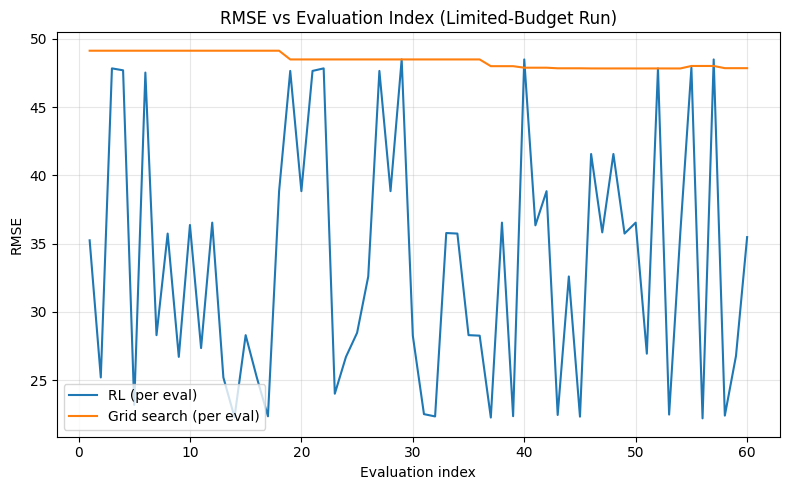

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure limited_results is available
rl_step_history = limited_results["rl_step_history"]
grid_results = limited_results["grid_results"]

# RL: per‑evaluation RMSE (skip None)
rl_evals = []
rl_rmses = []
for s in rl_step_history:
    if s["rmse"] is not None:
        rl_evals.append(s["eval"])
        rl_rmses.append(s["rmse"])

# Grid: per‑evaluation RMSE
grid_evals = list(range(1, len(grid_results) + 1))
grid_rmses = [r["rmse"] for r in grid_results]

plt.figure(figsize=(8, 5))
plt.plot(rl_evals, rl_rmses, label="RL (per eval)")
plt.plot(grid_evals, grid_rmses, label="Grid search (per eval)")

plt.xlabel("Evaluation index")
plt.ylabel("RMSE")
plt.title("RMSE vs Evaluation Index (Limited‑Budget Run)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

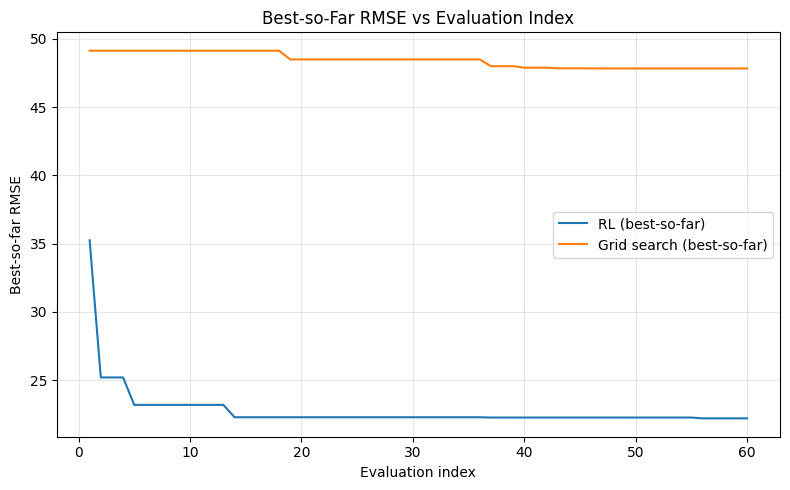

In [32]:
# Compute best‑so‑far curves for RL and grid search

# RL best‑so‑far
rl_best_so_far = []
best = float("inf")
for v in rl_rmses:
    if v < best:
        best = v
    rl_best_so_far.append(best)

# Grid best‑so‑far
grid_best_so_far = []
best = float("inf")
for v in grid_rmses:
    if v < best:
        best = v
    grid_best_so_far.append(best)

plt.figure(figsize=(8, 5))
plt.plot(rl_evals, rl_best_so_far, label="RL (best‑so‑far)")
plt.plot(grid_evals, grid_best_so_far, label="Grid search (best‑so‑far)")

plt.xlabel("Evaluation index")
plt.ylabel("Best‑so‑far RMSE")
plt.title("Best‑so‑Far RMSE vs Evaluation Index")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


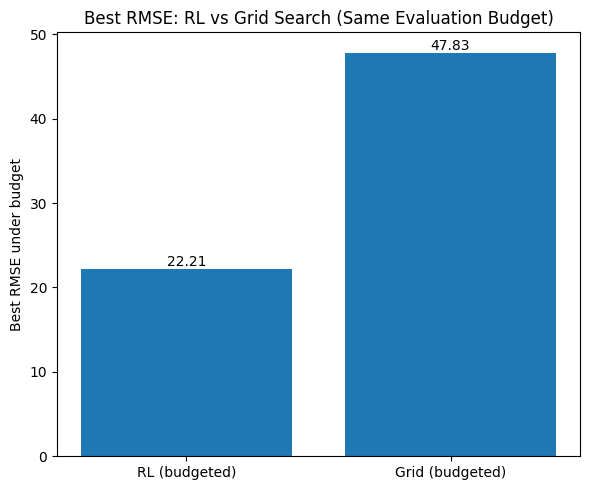

In [33]:

rl_best = limited_results["rl_best_rmse"]
grid_best = limited_results["grid_best_rmse"]

methods = ["RL (budgeted)", "Grid (budgeted)"]
values = [rl_best, grid_best]

plt.figure(figsize=(6, 5))
x_pos = np.arange(len(methods))
plt.bar(x_pos, values)
plt.xticks(x_pos, methods)
plt.ylabel("Best RMSE under budget")
plt.title("Best RMSE: RL vs Grid Search (Same Evaluation Budget)")
for i, v in enumerate(values):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

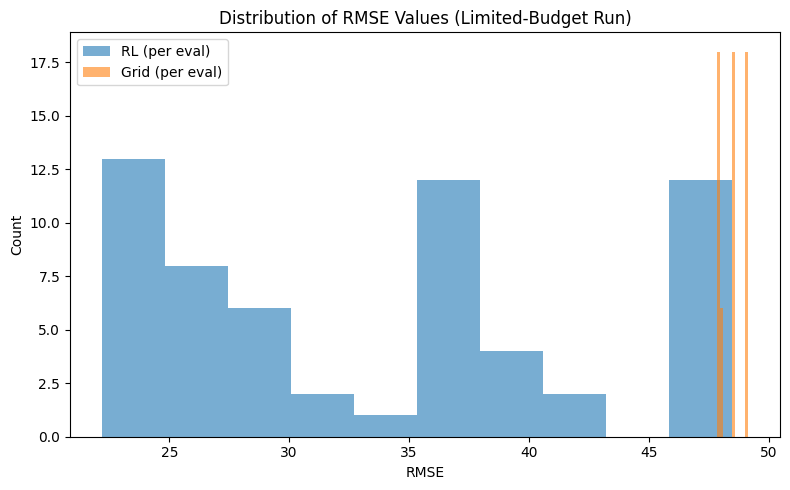

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(rl_rmses, bins=10, alpha=0.6, label="RL (per eval)")
plt.hist(grid_rmses, bins=10, alpha=0.6, label="Grid (per eval)")
plt.xlabel("RMSE")
plt.ylabel("Count")
plt.title("Distribution of RMSE Values (Limited‑Budget Run)")
plt.legend()
plt.tight_layout()
plt.show()


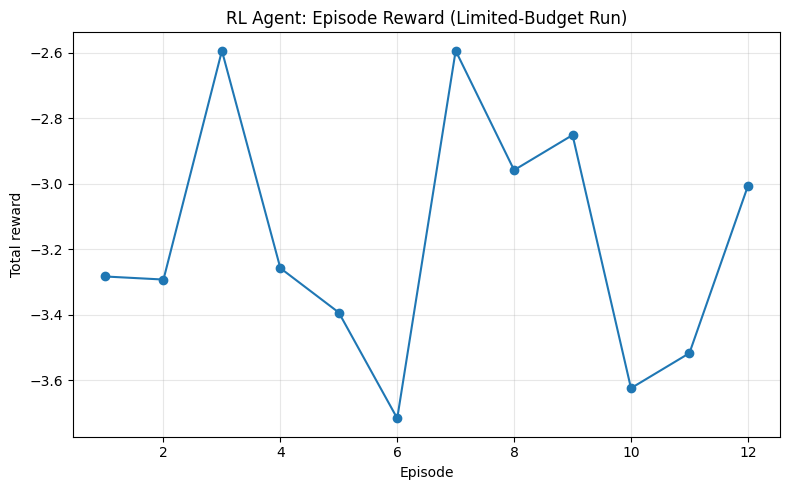

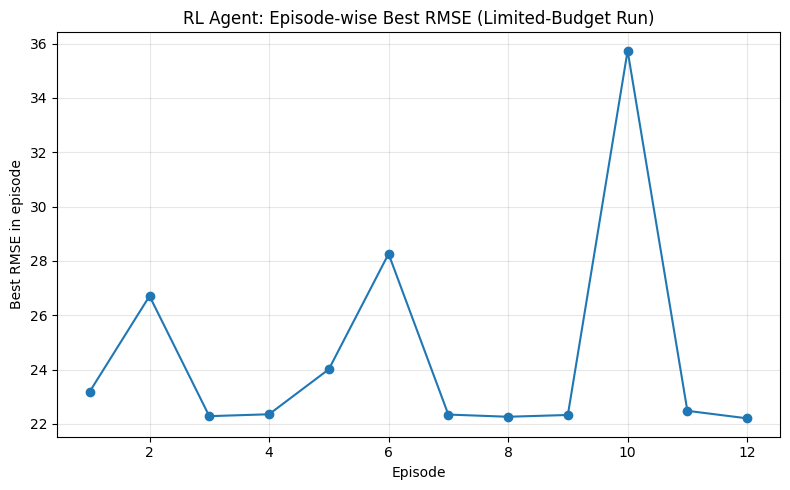

In [35]:
# Derive episode‑level reward and RMSE from step history
episode_rewards = []
episode_min_rmse = []

current_episode = None
current_ep_rewards = []
current_ep_rmses = []

for s in rl_step_history:
    ep = s["episode"]
    if current_episode is None:
        current_episode = ep

    if ep != current_episode:
        # finalize previous episode
        if current_ep_rewards:
            episode_rewards.append(current_ep_rewards[-1])  # final cumulative reward
        if current_ep_rmses:
            episode_min_rmse.append(min(current_ep_rmses))
        # reset for next
        current_episode = ep
        current_ep_rewards = []
        current_ep_rmses = []

    current_ep_rewards.append(s["cumulative_reward"])
    if s["rmse"] is not None:
        current_ep_rmses.append(s["rmse"])

# finalize last episode
if current_ep_rewards:
    episode_rewards.append(current_ep_rewards[-1])
if current_ep_rmses:
    episode_min_rmse.append(min(current_ep_rmses))

episodes = np.arange(1, len(episode_rewards) + 1)

# Plot episode rewards
plt.figure(figsize=(8, 5))
plt.plot(episodes, episode_rewards, marker="o")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("RL Agent: Episode Reward (Limited‑Budget Run)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot episode‑wise best RMSE
plt.figure(figsize=(8, 5))
plt.plot(episodes, episode_min_rmse, marker="o")
plt.xlabel("Episode")
plt.ylabel("Best RMSE in episode")
plt.title("RL Agent: Episode‑wise Best RMSE (Limited‑Budget Run)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

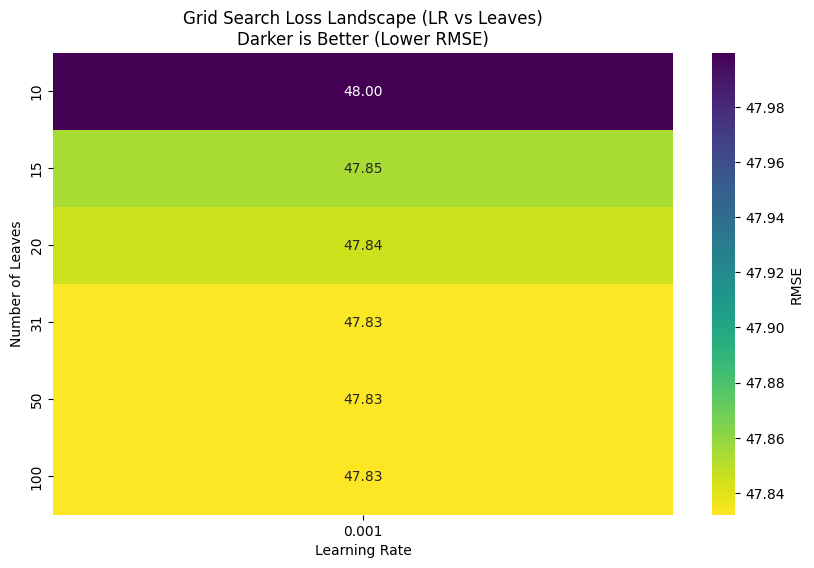

In [36]:
grid_data = []
for res in limited_results['grid_results']:
    row = res['params'].copy()
    row['rmse'] = res['rmse']
    grid_data.append(row)

df_grid = pd.DataFrame(grid_data)

# 2. Create the Plot (Learning Rate vs Num Leaves)
plt.figure(figsize=(10, 6))

# Use pivot table to prepare for heatmap
pivot_table = df_grid.pivot_table(values='rmse', index='num_leaves', columns='learning_rate', aggfunc='min')

# Draw Heatmap
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis_r", cbar_kws={'label': 'RMSE'})

# 3. Highlight RL Agent's Final Choice (Optional)
# Assuming rl_best_config is available from your results
rl_best = limited_results['rl_best_config']
# You would manually mark the cell or draw a star where the RL ended up
# (This requires matching the RL final params to the grid coordinates)

plt.title('Grid Search Loss Landscape (LR vs Leaves)\nDarker is Better (Lower RMSE)')
plt.ylabel('Number of Leaves')
plt.xlabel('Learning Rate')
plt.show()

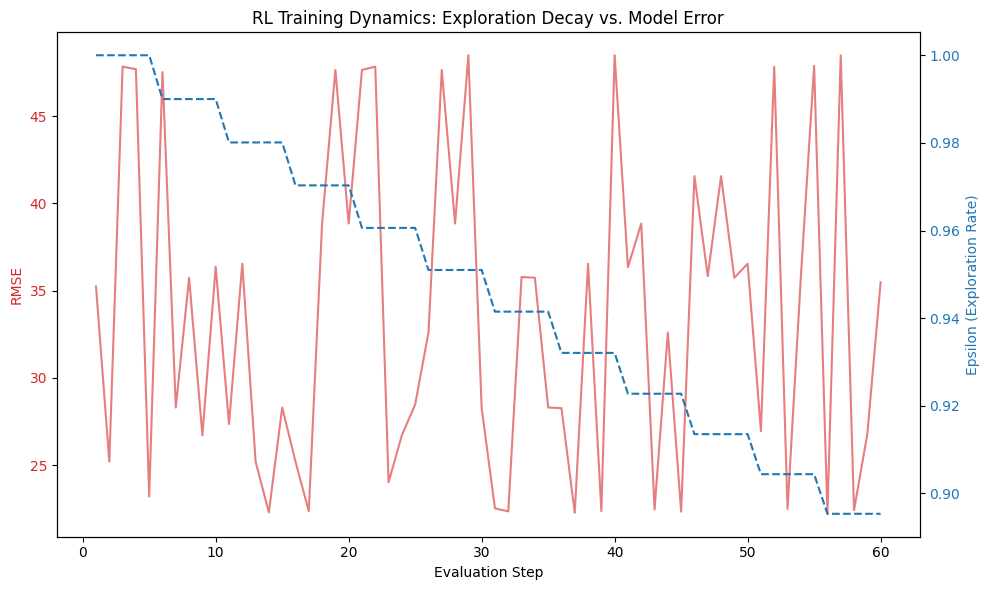

In [37]:
# Extract data
eval_indices = [x['eval'] for x in limited_results['rl_step_history'] if x['rmse'] is not None]
rmse_values = [x['rmse'] for x in limited_results['rl_step_history'] if x['rmse'] is not None]
epsilon_values = [x['epsilon'] for x in limited_results['rl_step_history'] if x['rmse'] is not None]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSE on Left Y-Axis
color = 'tab:red'
ax1.set_xlabel('Evaluation Step')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(eval_indices, rmse_values, color=color, alpha=0.6, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Epsilon on Right Y-Axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Epsilon (Exploration Rate)', color=color)
ax2.plot(eval_indices, epsilon_values, color=color, linestyle='--', label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('RL Training Dynamics: Exploration Decay vs. Model Error')
fig.tight_layout()
plt.show()